In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw08.ipynb")

# Homework 8: Probability and Estimators
## Due Date: Thursday, July 25th, 11:59 PM PT

You must submit this assignment to Gradescope by the on-time deadline, Thursday, July 25th, 11:59 PM PT. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for support if you encounter difficulties with submission. While course staff is happy to help guide you with submitting your assignment ahead of the deadline, we will not respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully when submitting your work to Gradescope.


## Content Warning

This assignment includes an analysis of daily COVID-19 cases by U.S. county through 2021. If you feel uncomfortable with this topic, **please contact your TA or the instructors.**


## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*

## Introduction

In this homework, we will investigate a dataset that contains information about COVID-19 cases in the United States, vaccination rates, and various other metadata that can assist in modeling different aspects of COVID-19.

Through this homework assignment, you will demonstrate your experience with:
* Bootstrap sampling,
* Bias-variance tradeoff and decomposition, and
* Multicollinearity in features.

## Grading
Grading is broken down into auto-graded answers and free responses. 

For auto-graded answers, the results of your code are compared to provided and/or hidden tests.

For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question. 

### Score breakdown

Question | Manual | Points
--- |---| ---
0 | No | 1
1a| No | 3
1b| No | 1
1c| Yes | 3
1d| Yes | 2
1e| Yes | 1
2a| No | 4
2b| Yes |3
2c| Yes | 1
3a| No | 2
3b| No | 4
3c| No | 2
3d| Yes | 3
4a| No | 3
4b| Yes | 3
4c| No | 2
4d| Yes | 2
Total | 8 | 40

If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). 

In [1]:
# Run this cell to set up your notebook
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown

import scipy.stats

import warnings
warnings.filterwarnings("ignore")

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 0: Week 6 Check-In

Please fill out the following quick, anonymous check-in survey: [LINK](https://forms.gle/ricjE5yuH8tSGQkBA). At the end you will see a secret word, please set `q0` to this secret word as a string. 

If you fill out the form and forget to take note of the secret word, just click the form link again and you will see the secret word along with a message that you've already filled the form out!

In [4]:
q0 = "..."
q0

'...'

In [5]:
grader.check("q0")

q0 results: All test cases passed!

<br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Exploratory Data Analysis

Let's perform some initial exploratory data analysis to examine and visualize potential trends in a COVID-19 dataset.

In [6]:
# Run this cell to load the data; no further action is needed.
covid_data = pd.read_csv('data/covid_data.csv')
covid_data.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,84001001,US,USA,840,1001,Autauga,Alabama,US,32.539527,-86.644082,...,55533,55769,56130,56145,1001,0.053,0.074,0.134,0.295,0.444
1,84001003,US,USA,840,1003,Baldwin,Alabama,US,30.727750,-87.722071,...,218071,223565,227989,229287,1003,0.083,0.059,0.098,0.323,0.436
2,84001005,US,USA,840,1005,Barbour,Alabama,US,31.868263,-85.387129,...,24887,24657,24652,24589,1005,0.067,0.121,0.120,0.201,0.491
3,84001007,US,USA,840,1007,Bibb,Alabama,US,32.996421,-87.125115,...,22300,22313,22199,22136,1007,0.020,0.034,0.096,0.278,0.572
4,84001009,US,USA,840,1009,Blount,Alabama,US,33.982109,-86.567906,...,57770,57840,57932,57879,1009,0.053,0.114,0.180,0.194,0.459


The data have granularity at the county level; each row corresponds to COVID-19 data from one U.S. county. Here are some highlights and data sources:

* The first few columns encode county and state data. Check out the [Federal Information Processing System (FIPS)](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) numeric encoding for U.S. counties.
* The next 600 columns record daily COVID-19 cases in the county for the date range 1/22/2020 to 9/12/2021. COVID-19 case data are from Center for Systems Sciences and Engineering (CSSE) at Johns Hopkins University [GitHub](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv).
* The next few columns include county populations from [U.S. census data](https://data.census.gov/), the latest of which is 2020.
* The last 5 columns record mask usage survey data on a 5-point scale from `NEVER` to `ALWAYS`. The data was collected in July 2020 from the New York Times [GitHub](https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv). Each column represents the proportion of the population in that county who never/rarely/sometimes/frequently/always wear masks. Note, for a particular row, the numbers in those five columns sum up to $1$.

We can use `covid_data.describe()` to see various statistics about the numerical features of the provided COVID-19 data. Do any particular statistics stand out to you? Which might be useful when modeling?

**Note:** This isn't a question, so it's not worth any points. This is just food for thought as you start to explore the dataset.

In [7]:
# Run this cell to load the data see see statistics of the covid_data
covid_data.describe()

,UID,code3,FIPS,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
count,3.141000e+03,3141.0,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,...,3.141000e+03,3.141000e+03,3.141000e+03,3.141000e+03,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000
mean,8.403039e+07,840.0,30392.602674,38.448156,-92.272006,0.000318,0.000318,0.000637,0.000637,0.001592,...,1.040525e+05,1.045274e+05,1.048677e+05,1.048949e+05,30392.602674,0.079952,0.082929,0.121340,0.207728,0.508044
std,1.515661e+04,0.0,15156.613190,5.292540,12.909318,0.017843,0.017843,0.025230,0.025230,0.039873,...,3.326200e+05,3.332156e+05,3.335848e+05,3.333719e+05,15156.613190,0.058543,0.055469,0.058007,0.063581,0.152190
min,8.400100e+07,840.0,1001.000000,19.601212,-174.159600,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.700000e+01,8.700000e+01,9.000000e+01,8.700000e+01,1001.000000,0.000000,0.000000,0.001000,0.029000,0.115000
25%,8.401818e+07,840.0,18179.000000,34.693167,-98.218207,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.096300e+04,1.093600e+04,1.091900e+04,1.092100e+04,18179.000000,0.034000,0.040000,0.079000,0.164000,0.393000
50%,8.402918e+07,840.0,29177.000000,38.373019,-90.396561,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.583700e+04,2.573500e+04,2.570100e+04,2.565800e+04,29177.000000,0.068000,0.073000,0.115000,0.204000,0.497000
75%,8.404508e+07,840.0,45081.000000,41.802830,-83.436796,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.813600e+04,6.828200e+04,6.822000e+04,6.824100e+04,45081.000000,0.113000,0.115000,0.156000,0.247000,0.613000
max,8.405604e+07,840.0,56045.000000,69.314792,-67.628135,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.006153e+07,1.001160e+07,9.968969e+06,9.943046e+06,56045.000000,0.432000,0.384000,0.422000,0.549000,0.889000


<br>

---

### Question 1a

In this homework, we will use linear regression to predict **the number of COVID-19 cases  per capita on September 12th, 2021**. Define a column `'9/12/2021_cpc'` in `covid_data` corresponding to **the number of cases per capita** on September 12th, 2021. 

Note that we will **always** use the `'POPESTIMATE2020'` as the population of each county.

*Hint*: The number of cases per capita should be the total number of cases in a county divided by the population of the county.

In [13]:
covid_data['9/12/2021_cpc'] = covid_data["9/12/21"] / covid_data["POPESTIMATE2020"]

In [14]:
grader.check("q1a")

q1a results: All test cases passed!

<br>

---

### Question 1b

Assign `mask_data` to a `DataFrame` with six columns from the original `covid_data` table: the five mask usage columns described earlier and the `9/12/2021_cpc` column.

**Note**: You should make a **copy** of these columns using `.copy()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html)). This ensures that `covid_data` will not change if `mask_data` is modified, and vice versa. 

In [19]:
mask_data = covid_data[["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS", "9/12/2021_cpc"]].copy()
mask_data

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,9/12/2021_cpc
0,0.053,0.074,0.134,0.295,0.444,0.165411
1,0.083,0.059,0.098,0.323,0.436,0.152429
2,0.067,0.121,0.120,0.201,0.491,0.134003
3,0.020,0.034,0.096,0.278,0.572,0.171440
4,0.053,0.114,0.180,0.194,0.459,0.158538
...,...,...,...,...,...,...
3136,0.061,0.295,0.230,0.146,0.268,0.143205
3137,0.095,0.157,0.160,0.247,0.340,0.196238
3138,0.098,0.278,0.154,0.207,0.264,0.158496
3139,0.204,0.155,0.069,0.285,0.287,0.144330


In [20]:
grader.check("q1b")

q1b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

### Question 1c

Our goal is to use county-wise mask usage data to predict the number of COVID-19 cases per capita on September 12th, 2021 (i.e., the column `9/12/2021_cpc`). But before modeling, let's do some EDA to explore the multicollinearity in these features, and then we will revisit this in question. 

Create a visualization that shows the pairwise correlation between each combination of columns in `mask_data`. For 2-D visualizations, consider Seaborn's [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html). Remember to title your plot.

**Hint**: You should be plotting 36 values corresponding to the [pairwise correlations](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) of the six columns in `mask_data`. You may optionally set `annot=True`, but it isn't necessary.

<Axes: >

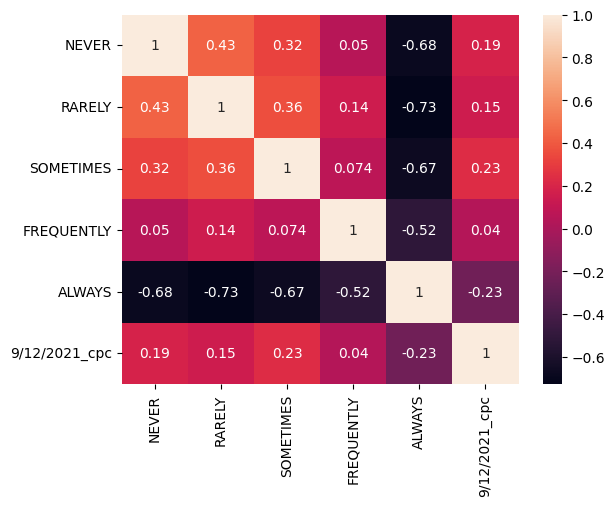

In [25]:
sns.heatmap(mask_data.corr(), annot=True)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

### Question 1d
Describe the trends and takeaways visible in the visualization of pairwise correlations you plotted in part (c). Specifically, what does the correlation between pairs of features (i.e., mask usage categories) look like? What does the correlation between mask usage categories and COVID-19 cases per capita look like?

...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---
### Question 1e
If we were to build a linear regression model (with an intercept term) using all five mask usage columns as features, what problem would we encounter?

_Mulitcollinearity._

<!-- END QUESTION -->

<br/>

<hr style="border: 1px solid #fdb515;" />

## Question 2: Creating a Preliminary COVID-19 Model

This question will guide you through creating a linear regression model that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this model in the next two questions.

<br>

---

### Question 2a

Despite the problems we discussed in the previous question, let's train a linear regression model with an intercept term using `scikit-learn` to predict the number of COVID-19 cases per capita for September 12, 2021, using county-wise mask usage data from `mask_data`. Use `train_test_split` [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to evaluate your model's RMSE on a held-out test set with 33% of the COVID-19 data; call the resulting splits `X_train`, `X_test`, `Y_train`, and `Y_test`.

To pass the autograder, make sure to set the parameter `random_state` to 42 in your call to `train_test_split` to generate a reproducible data split ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

In [36]:
# Create train/test sets
X = mask_data[["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]]
Y = mask_data["9/12/2021_cpc"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Fit the linear model and make predictions (you will need multiple lines)
model = lm.LinearRegression()
model.fit(X_train, Y_train)
Y_train_hat = model.predict(X_train)
Y_test_hat = model.predict(X_test)

# Compute RMSE on train and test sets
train_rmse_cpc = np.sqrt(np.mean((Y_train - Y_train_hat)**2))
test_rmse_cpc = np.sqrt(np.mean((Y_test - Y_test_hat)**2))

train_rmse_cpc, test_rmse_cpc

(0.03552339478226883, 0.037954861477287)

In [37]:
grader.check("q2a")

q2a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

### Question 2b

To visualize the model performance from part (a), let's make the following two visualizations: 
1. The observed values vs. the predicted values on the test set.
2. The residuals plot (note: in multiple linear regression, the residual plot has the residuals plotted against the predicted values).

In both plots, the predicted values should be on the x-axis so that it is easy to make comparisons.

**Note:**
* We've used `plt.subplot` ([documentation](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)) so that you can view both visualizations side-by-side. For example, `plt.subplot(121)` sets the plottable area to the first column of a 1x2 plot grid; you can then call `Matplotlib` and `Seaborn` functions to plot that area, before the next `plt.subplot(122)` area is set.
* **Remember to add a guiding line to both plots where $\hat{Y} = Y$, i.e., where the residual is 0**. `plt.plot` and `plt.axhline` might be helpful here!
* Consider setting the x-axes of the plots to have the same limits to make it easier to compare the graphs.
* Please add descriptive titles and axis labels for your plots!

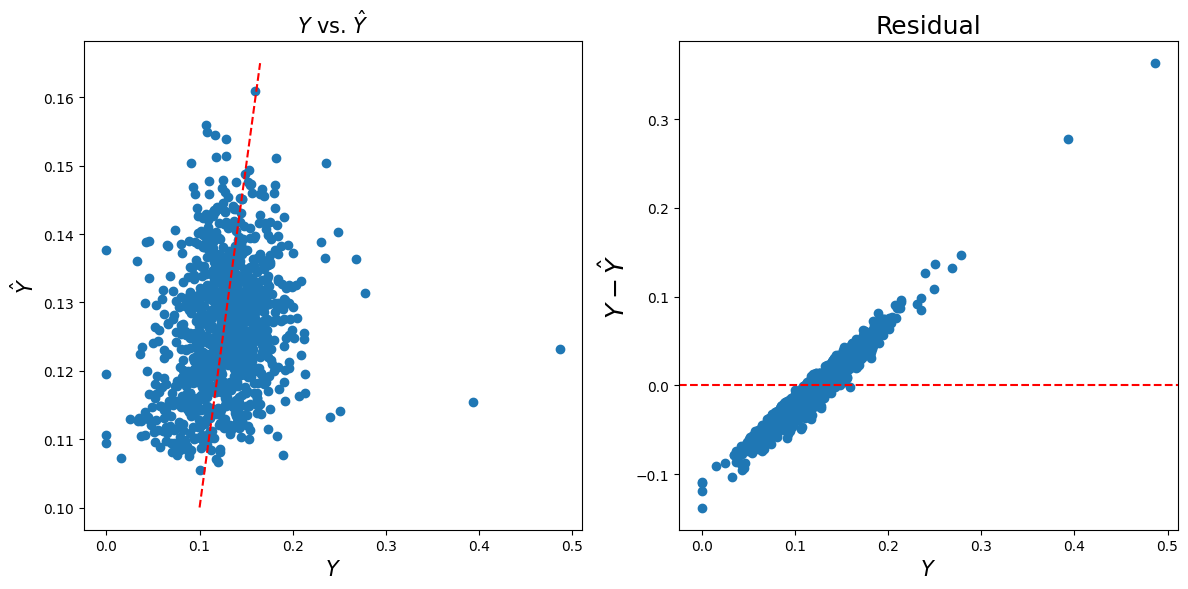

In [70]:
plt.figure(figsize=(12,6))      # do not change this line
plt.subplot(121)                # do not change this line
# 1. plot observations vs. predictions
plt.scatter(Y_test, Y_test_hat)
plt.plot([0.1, 0.165], [0.1, 0.165], c="r", ls="--")
plt.xlabel("$Y$", fontsize=15)
plt.ylabel("$\hat{Y}$", fontsize=15)
plt.title("$Y$ vs. $\hat{Y}$", fontsize=15)

plt.subplot(122)               # do not change this line
# 2. plot residual plot
plt.scatter(Y_test, Y_test - Y_test_hat)
plt.axhline(0, color="red", ls="--")
plt.xlabel("$Y$", fontsize=15)
plt.ylabel("$Y - \hat{Y}$", fontsize=18)
plt.title("Residual", fontsize=18)

plt.tight_layout()             # do not change this line

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

### Question 2c

Describe what the plots in part (b) indicate about this linear model. In particular, are the predictions good?

_Terrible._

<!-- END QUESTION -->

<br/>

<hr style="border: 1px solid #fdb515;" />

## Question 3: Performing Multicollinearity Analysis

This question will guide you through performing an analysis that can reveal potential multicollinearity in our features, which is not ideal. In particular, we will use bootstrapping to get $95\%$ confidence intervals on the fitted parameters. Here's a reminder of the outline of bootstrapping:

1. `3a` Assume the sample is a representative sample. We can simulate different samples by resampling from the original sample.
2. `3b` Calculate statistic(s) for each resample to simulate different potential result. Statistics can be a mean (Lab 10), correlation (Lab 10), coefficients of a linear model (Question 3 below), and any function of the sample data.
3. `3c` Use the distribution of the above statistics calculated on each of the resamples to construct a confidence interval.
4. `3d` Use the result of the confidence interval to make an inference of the population.

<br>

---

### Question 3a

Fill in the blanks below to implement the `bootstrap_sample` function that performs bootstrapping on the given dataset `data` $k$ times. To perform a bootstrap on a `DataFrame` with $n$ rows, randomly draw $n$ samples *with replacement* so that the bootstrapped `DataFrame` is the same size as the original `DataFrame`. The `bootstrap_sample` function should return a list containing $k$ bootstrapped `DataFrames`, each of which has $n$ rows.

**Hint**: You may find `df.sample` helpful, see [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html). This is very similar to Lab 10.

In [72]:
def bootstrap_sample(data, k):
    """
    Performs bootstrap sampling on data to obtain k samples of size n.
    
    Arguments:
        data - Dataset contained as a Pandas DataFrame 
        k - Number of randomly drawn samples
    
    Returns:
        samples - List containing k Pandas DataFrames of size n each
                  corresponding to each sample  
    """
    n = len(data)
    samples = []
    for _ in range(k):
        sample = data.sample(n, replace=True)
        samples.append(sample)
    return samples

# Print out the first DataFrame only
bootstrap_sample(mask_data, 1)[0]

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,9/12/2021_cpc
443,0.035,0.048,0.083,0.193,0.641,0.119140
2029,0.081,0.163,0.249,0.251,0.257,0.134935
2467,0.063,0.057,0.082,0.217,0.581,0.160043
867,0.144,0.138,0.281,0.162,0.275,0.128307
2551,0.049,0.060,0.119,0.205,0.567,0.109993
...,...,...,...,...,...,...
3034,0.082,0.024,0.191,0.210,0.493,0.073876
1056,0.129,0.069,0.129,0.273,0.399,0.214915
258,0.087,0.094,0.074,0.295,0.450,0.106222
1674,0.113,0.167,0.131,0.163,0.425,0.196263


In [73]:
grader.check("q3a")

q3a results: All test cases passed!

<br>

---

### Question 3b

Using the function from the previous part, let's do the following:

1. Generate 1000 bootstrapped samples from the original `mask_data` `DataFrame`. 
2. For each of the 1000 bootstrapped samples, use `sklearn` to fit a linear regression model (with an intercept term) like we did in Question 2, where mask usage categories are the features and `9/12/2021_cpc` is the response. You should fit 1000 models in total. 
3. Store each of the 1000 trained models in the `models` list.

**Hint:**
* You *should not* create any validation or testing sets in this subpart; each model should fit to one entire bootstrapped `DataFrame`.
* `LinearRegression` is an object type; to store a new model you must create a new instance first!
* Do not use `X` and `Y` as variable names while bootstrapping as this will override the values stored in `q2a`.
* When fitting each model, remember that your design matrix should be a 2D array or `pandas` `DataFrame` whereas the true labels should be a `Series`.

In [77]:
np.random.seed(42) # DO NOT REMOVE THIS LINE

datasets = bootstrap_sample(mask_data, 1000)
models = []
for dataset in datasets:
    model = lm.LinearRegression()
    model.fit(dataset[["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]], dataset["9/12/2021_cpc"])
    models.append(model)

# Datasets take up a lot of memory, so we should remove them!
del datasets

In [78]:
grader.check("q3b")

q3b results: All test cases passed!

<br>

---

### Question 3c

Fill in the blanks below in the `confidence_interval` function to generate a $95\%$ confidence interval for each of our parameters $\theta_i$, including the intercept term $\theta_0$. All of the helper code to extract coefficients from our trained models has been implemented for you already.

**Hint**: 
- For a refresher on confidence intervals, refer to this section in the [Data 8 textbook](https://inferentialthinking.com/chapters/13/3/Confidence_Intervals.html). 
- Pay close attention to how the arrays used below are formatted. What does each row represent? What does each column represent? To get the $i$th column from a 2D-array, you can use `2D_array[:, i]`.


In [82]:
def extract_coefs(models, include_intercept = True):
    """
    NOTE: This function has already been implemented. You do not need to modify this!
    
    Extracts coefficients of all the linear regression models in MODELS and returns
    it as a NumPy array with one model's coefficients as each row.
    
    Arguments:
        models - Contains k sklearn LinearRegression models, each with p + 1 coefficients.
        include_intercept - Whether to include an intercept in returned coefficients.
    
    Returns:
        coef_array - Coefficients of all k models, each with p + 1 coefficients (if intercept
                     enabled, otherwise p). The returned object is k x (p + 1) NumPy array.
    """
    coef_array = np.zeros(shape = (len(models), len(models[0].coef_) + 1))
    for i, m in enumerate(models):
        coef_array[i, 0] = m.intercept_
        coef_array[i, 1:] = m.coef_
    if include_intercept:
        return coef_array 
    return coef_array[:, 1:]

def confidence_interval(coefs):
    """
    Calculates confidence intervals for each theta_i based on coefficients of 
    bootstrapped models. Returns output as a list of confidence intervals.
    
    Arguments:
        coefs - Output of extract_coefs, a k x (p + 1) or k x p NumPy array containing
                coefficients of bootstrapped models.
    
    Returns:
        cis - Confidence intervals of each parameter theta_i in the form of a 
              list like this: [(0.5, 0.75), (0.2, 0.4), ...].
    """
    cis = []
    
    # FILL IN CODE BELOW
    for i in range(len(coefs[0])):
        theta_i_values = coefs[:, i]
        theta_i_lower_ci, theta_i_upper_ci = np.percentile(theta_i_values, 2.5), np.percentile(theta_i_values, 97.5)
        cis.append((theta_i_lower_ci, theta_i_upper_ci))
    
    return cis


# Compute confidence intervals
model_coefs = extract_coefs(models)
cis = confidence_interval(model_coefs)

# Pretty print in a table
display(Markdown('#### Confidence Intervals:'))
md_list = ["|parameter|lower|upper|",
           "----|----|----|"]
md_list += [fr"|$\theta_{i}$|{lci}|{uci}|" for i, (lci, uci) in enumerate(cis)]
display(Markdown('\n'.join(md_list)))

#### Confidence Intervals:

|parameter|lower|upper|
----|----|----|
|$\theta_0$|-2.6200726729046546|1.2507871842260834|
|$\theta_1$|-1.089682887413483|2.798332585238311|
|$\theta_2$|-1.14613315408184|2.7445190254359266|
|$\theta_3$|-1.0182943692233446|2.8436420433761893|
|$\theta_4$|-1.1582158941590666|2.732939257340753|
|$\theta_5$|-1.1477854499076416|2.719510905202876|

In [83]:
grader.check("q3c")

q3c results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

### Question 3d

Interpret the confidence intervals above for each of the $\theta_i$, where $\theta_0$ is the intercept term, and the remaining $\theta_i$'s are parameters corresponding to mask usage features. How does this relate to your observations in `q1d`, and what does that indicate about the usefulness of all the features for your model?

Hint: The lecture or [course notes](https://ds100.org/course-notes/inference_causality/inference_causality.html) discussing collinearity might be a useful starting point when approaching this question.

Can not reject $H_0$. Must remove one independent vairable to solve multicollinearity.

<!-- END QUESTION -->

<br/>

<hr style="border: 1px solid #fdb515;" />

## Question 4: Performing Bias-Variance Analysis

This question will guide you through performing an analysis that can estimate the bias and variance of our models, which can be helpful in modeling.

Recall that the **model variance** on a data point $\vec{x_k}$ is simply the variance of our predictions on that sample point $\vec{x_k}$. 

$$\text{model variance} = \mathrm{Var}(\hat{Y}(\vec{x_k})) = \mathrm{Var}(\vec{x_k}^T\hat{\theta})$$

Since we are using OLS, we can also rewrite our model as $\hat{Y}(\vec{x_k}) = \vec{x_k}^T\hat{\theta} = \hat{\theta_0} 1 + \hat{\theta_1}x_{k, 1} + ... + \hat{\theta_p}x_{k, p}$. To estimate the model variance, we can sample a particular data point $(\vec{x_k}, y_k)$ and calculate the variance of the predictions using different fitted models in `models`. Note that the variance is taken across different models $\hat{Y}(\vec{x_k})$, which are pre-selected and fixed. 

Also, recall that **model risk** for this point is the same as the mean square error over all possible fitted models:

$$
\text{model risk} = \mathbb{E}\left[\left(y_k - \hat{Y}(\vec{x_k}) \right)^2\right] \approx \frac{1}{\# \text{ of bootstrap}}\sum_{j=1}^{\# \text{ of bootstrap}} (y_k - \hat{Y}_j(\vec{x_k}))^2 = MSE(\vec{x_k})
$$

where the subscript $j$ is used to denote different models. Here, we are considering a particular observation of the random response variable $y_k$. Therefore model risk is an expectation over the estimate $\hat{\theta}_j$, coefficients corresponding to different models. $\hat{\theta}_j$ itself is a random variable because it was derived by fitting to different random resamples. We can also find the ratio of model variance to model risk. You can interpret this ratio as the proportion of the expected square error on the data point "captured" or "explained" by the model variance: 

$$
\frac{\text{model variance}}{\text{model risk}}=\frac{\mathrm{Var}(\hat{Y}(\vec{x_k}))}{\mathbb{E}\left[\left(y_k - \hat{Y}(\vec{x_k}) \right)^2\right]}
$$

<br>

---

### Question 4a

Let's use the last row of our design matrix `X` and its corresponding `Y` value to find these quantities! Recall we defined `X` and `Y` back in Question `2a`, which is what you should be referencing here.

Complete the function `simulate` that takes in a data point `xk`, `yk` and returns `model_risk`, `model_var`, and `ratio`, the ratio of model variance to model risk.

Here is a suggested format, but you do not need to follow the skeleton code:
* Assign `predictions` to a length 1000 vector where each element is the prediction on `xk` using a model in `models`. Note that `sklearn`'s `.predict` returns an array, but we only need a **scalar prediction**! Try to print out a prediction and adjust your code if needed.
* Use `predictions` to compute the estimated `model_risk`.
* Use `predictions` to compute the estimated `model_var`.
* Use `model_risk` and `model_var` to compute the `ratio`, the ratio of model variance to model risk.

**Hint**: You can use list comprehension for creating your predictions to save yourself the overhead of using multiple appends, as well as `np.mean` and `np.var` for computing means and variances of an array or list.

In [101]:
def simulate(xk, yk, models):
    predictions = [model.predict(xk) for model in models]
    model_risk = np.mean((yk - predictions)**2)
    model_var = np.var(predictions)
    ratio = model_var / model_risk
    return model_risk, model_var, ratio
x_last = X.iloc[[-1]]
y_last = Y.iloc[-1]
model_risk, model_var, ratio = simulate(x_last, y_last, models)
model_risk, model_var, ratio

(0.000153458640941587, 9.816864640764886e-07, 0.006397075186207084)

In [102]:
grader.check("q4a")

q4a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

### Question 4b

Comment on the ratio `ratio`, which is the proportion of the expected square error on the data point captured by the model variance. Is the model variance the dominant term in the bias-variance decomposition? If not, what term(s) dominate the bias-variance decomposition?

**Note**: The Bias-Variance decomposition from the lecture is:

$$
\text{model risk} = \sigma^2 + (\text{model bias})^2 + \text{model variance}
$$

where $\sigma^2$ is the observation variance, or "irreducible error".


No. Model bias.

<!-- END QUESTION -->

<br>

---

### Question 4c

Now let's calculate the average variance and average mean squared error across 250 randomly sampled $(x_i, y_i)$ points. In other words, estimate the following quantities across all $x_i$ and $y_i$ in `X_sample` and `Y_sample`:

* Average variance is given by: $$\frac{1}{250} \sum_{k=1}^{250} \mathrm{Var}\left(\hat{Y}(\vec{x_k})\right)$$
* Average mean squared error is given by: $$\frac{1}{250} \sum_{k=1}^{250} \mathbb{E}\left[ (y_k - \hat{Y}(\vec{x_k}))^2 \right]$$

**Hint:** Call `simulate` from `q4a`.

Note that this question may take a little longer to run than usual. However, if your code runs for more than ~10 minutes, please reassess your code in `q4a` and `q4c`. 

In [105]:
np.random.seed(42)

X_sample = X.sample(250)         # Generate 250 x_i
Y_sample = Y.loc[X_sample.index] # and select the corresponding y_i

var, mse = [], []

# Write your code to calculate the variances and MSEs below
for i in range(250):
    x_k, y_k = X_sample.iloc[[i]], Y_sample.iloc[i]
    res = simulate(x_k, y_k, models)
    var.append(res[1])
    mse.append(res[0])

avg_var, avg_mse = np.mean(var), np.mean(mse)
avg_var, avg_mse

(2.5345984822549163e-06, 0.001609776631080761)

In [106]:
grader.check("q4c")

q4c results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

### Question 4d

Propose a method of reducing the mean square error using the insights gained from the bias-variance decomposition above.

Assume that the standard bias-variance decomposition used in lecture can be applied here.

Find a balance between underfitting(model bias) and overfitting(model variance).

<!-- END QUESTION -->

<br><br>


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Homework 8!

Here are some cats :) Can you find their names? There are two ways you can find them on JupyterLab.

<img src="images/Pandas.jpg" width="370px"/> <img src="images/Patches.jpg" width="200px" /> <img src="images/Pishi.jpg" width="208px" />


### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://forms.gle/owfPCGgnrju1xQEA9). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Homework 8 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Homework 8 Written assignment. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

**Important**: Please check that your **plots/graphs and written responses** were generated and submitted correctly to the Homework 8 Written Assignment.

**You are responsible for ensuring your submission follows our requirements and that the PDF for Homework 8 written answers was generated/submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [107]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q0 results: All test cases passed!

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q2a results: All test cases passed!

    q3a results: All test cases passed!

    q3b results: All test cases passed!

    q3c results: All test cases passed!

    q4a results: All test cases passed!

    q4c results: All test cases passed!
